# Testing the PILCO framework

In [1]:
# %load ~/dev/marthaler/header.py
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

In [2]:
# Enable Float64 for more stable matrix inversions.
import jax
import equinox as eqx
from jax import Array, config
import jax.numpy as jnp
import numpy as np
import jax.random as jr
from jaxtyping import ArrayLike, install_import_hook, Array, Float, Int, PyTree  
import matplotlib as mpl
import matplotlib.pyplot as plt

config.update("jax_enable_x64", True)

cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

In [3]:
import gymnasium as gym

In [5]:
from jax_mc_pilco.controllers import Controller, RandomController, SumOfGaussians
from jax_mc_pilco.rewards import pendulum_cost#, cart_pole_cost
from jax_mc_pilco.model_learning.gp_models import IMGPR
from jax_mc_pilco.policy_learning.rollout import fit_controller
from jax_mc_pilco.simulators.simulation import remake_state, sample_from_environment

In [6]:
import optax as ox

In [7]:
from IPython import display

## Globals

In [8]:
num_particles = 400
num_trials = 8
T_sampling = 0.05
T_exploration = 0.35
T_control = 3.0
sim_timestep = 0.01
starting_dropout_probability = 0.25
control_horizon = int(T_control / T_sampling)
num_basis = 200
umax = 2.0

## Generate the environments

In [9]:
env = gym.make("Pendulum-v1")

In [10]:
action_dim = env.action_space.shape[0]
x, _ = env.reset()
state_dim = x.shape[0]
# state is cos_theta, sin_theta, theta_dot

In [11]:
timesteps = np.linspace(0, T_exploration, int(T_exploration / sim_timestep) + 1)

## Initialize the Controllers

In [12]:
key = jr.key(42)

In [13]:
random_policy = RandomController(state_dim, action_dim, to_squash=True, max_action=umax)

control_policy = SumOfGaussians(
    state_dim,
    action_dim,
    num_basis,
    initial_log_lengthscales=None,
    initial_centers=None,
    use_dropout=True,
    dropout_probability=starting_dropout_probability,
    to_squash=True,
    max_action=umax,
    key=key
)

# Main Loop

step=0, train_loss=52.324891746697965, 
step=50, train_loss=52.33368611997905, 
step=100, train_loss=52.44105699910034, 
step=150, train_loss=52.438774108057665, 
Decreasing dropout probability at step=198, 0.25, 0.125
Decreasing dropout probability at step=199, 0.125, 0.0
step=200, train_loss=52.394565100097424, 
step=250, train_loss=52.4319977248003, 
step=300, train_loss=52.40864082792907, 
step=350, train_loss=52.41334004128439, 
step=400, train_loss=52.44114250072213, 
step=450, train_loss=52.40942443485843, 
step=500, train_loss=52.422353447238656, 
step=550, train_loss=52.40359802500481, 
step=600, train_loss=52.47395217577769, 
step=650, train_loss=52.40514673496376, 
step=700, train_loss=52.400038763257825, 
step=750, train_loss=52.378085933548476, 
step=800, train_loss=52.413805231686, 
step=850, train_loss=52.37730124492009, 
step=900, train_loss=52.4240363485912, 
step=950, train_loss=52.42622659532075, 
step=1000, train_loss=52.449792490092484, 
step=1050, train_loss=52.39

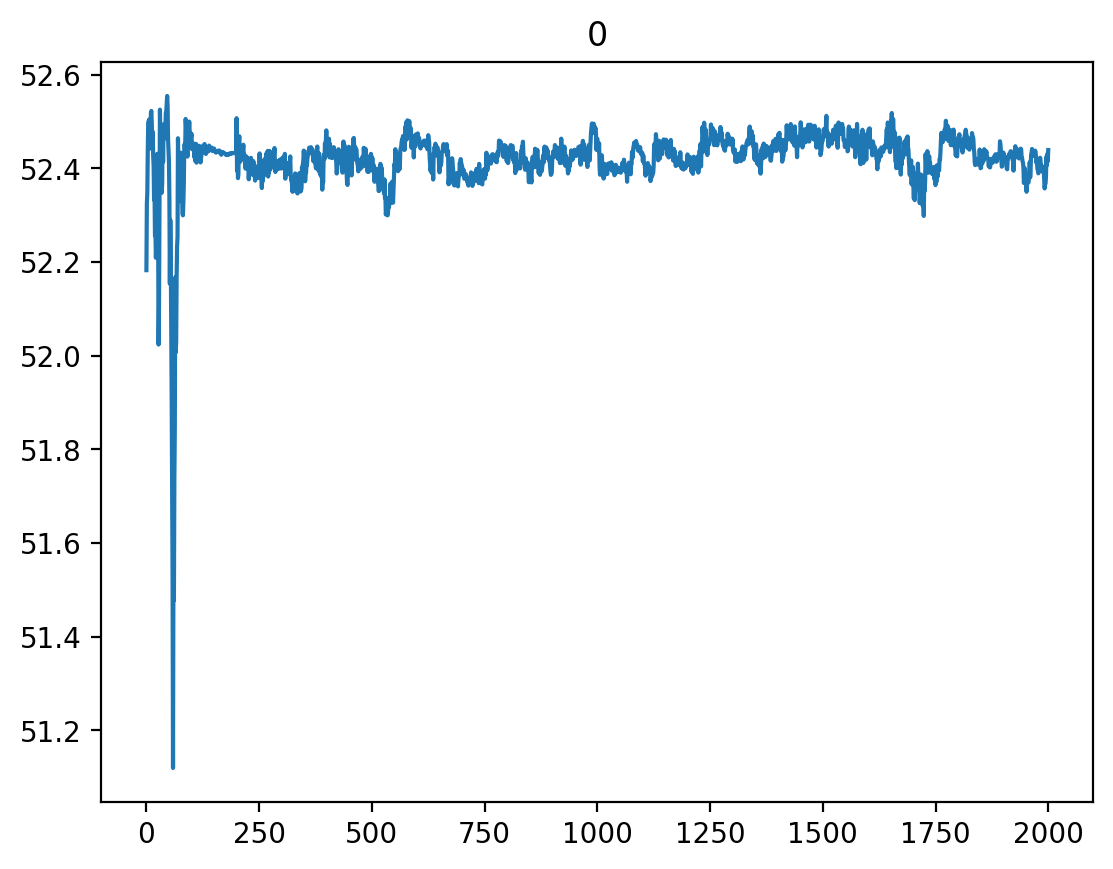

step=0, train_loss=39.40398646213581, 
step=50, train_loss=40.941147057699844, 
step=100, train_loss=40.400129974032694, 
step=150, train_loss=40.6465288044187, 
Decreasing dropout probability at step=198, 0.25, 0.125
Decreasing dropout probability at step=199, 0.125, 0.0
step=200, train_loss=39.940470877361086, 
step=250, train_loss=40.21106830120999, 
step=300, train_loss=40.37219316620422, 
step=350, train_loss=39.47420541851052, 
step=400, train_loss=39.72348264276688, 
step=450, train_loss=39.48324051077062, 
step=500, train_loss=39.60834955067341, 
step=550, train_loss=39.80736946694113, 
step=600, train_loss=39.552063578890355, 
step=650, train_loss=39.70055678859596, 
step=700, train_loss=39.6141528874206, 
step=750, train_loss=39.498186217562, 
step=800, train_loss=39.47849742170559, 
step=850, train_loss=39.740419900857304, 
step=900, train_loss=39.771981126961684, 
step=950, train_loss=39.8585088555711, 
step=1000, train_loss=39.955160107149275, 
step=1050, train_loss=39.516

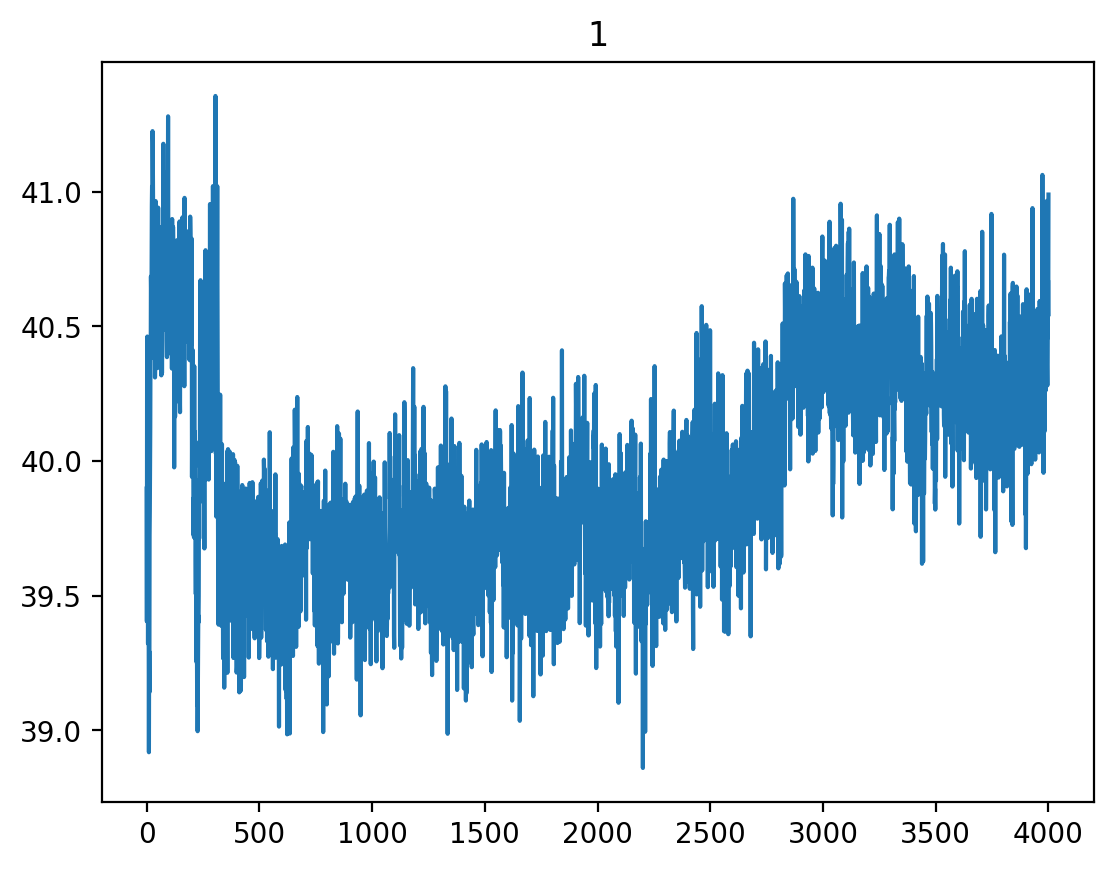

step=0, train_loss=41.70878217171545, 
step=50, train_loss=39.954254101375874, 
step=100, train_loss=39.74833445555868, 
step=150, train_loss=40.148285302773495, 
Decreasing dropout probability at step=198, 0.25, 0.125
Decreasing dropout probability at step=199, 0.125, 0.0
step=200, train_loss=40.90810413135382, 
step=250, train_loss=41.18555190784805, 
step=300, train_loss=40.69043536808432, 
step=350, train_loss=40.42496274631274, 
step=400, train_loss=41.018737182711305, 
step=450, train_loss=40.730061812773975, 
step=500, train_loss=40.57393643230931, 
step=550, train_loss=40.73903644107037, 
step=600, train_loss=40.73866844620568, 
step=650, train_loss=41.00383193155184, 
step=700, train_loss=40.797537027091124, 
step=750, train_loss=40.59863246496013, 
step=800, train_loss=40.73550968602458, 
step=850, train_loss=40.8777326779975, 
step=900, train_loss=40.96065979279082, 
step=950, train_loss=40.50846502845481, 
step=1000, train_loss=40.436306531872546, 
step=1050, train_loss=40.

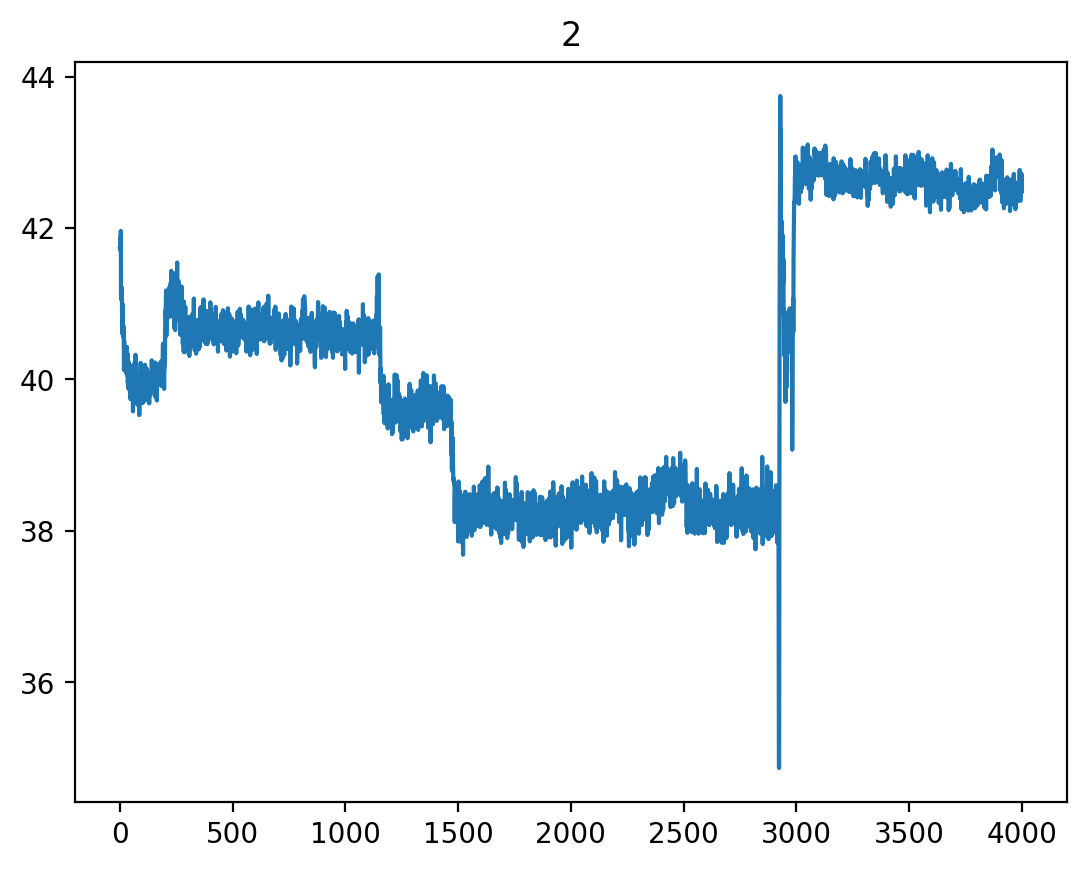

step=0, train_loss=43.97784427054696, 
step=50, train_loss=42.84559749500774, 
step=100, train_loss=43.601939235737646, 
step=150, train_loss=43.24981925948675, 
Decreasing dropout probability at step=198, 0.25, 0.125
Decreasing dropout probability at step=199, 0.125, 0.0
step=200, train_loss=43.18757762584865, 
step=250, train_loss=42.216841619395936, 
step=300, train_loss=42.65862373194209, 
step=350, train_loss=42.80916276025849, 
step=400, train_loss=42.97138031909855, 
step=450, train_loss=42.443827330617076, 
step=500, train_loss=42.72550885636389, 
step=550, train_loss=43.256881169491656, 
step=600, train_loss=43.25493371360015, 
step=650, train_loss=43.58706855015416, 
step=700, train_loss=43.29406790761377, 
step=750, train_loss=43.88427635593279, 
step=800, train_loss=44.0237608338708, 
step=850, train_loss=44.562883778392305, 
step=900, train_loss=43.99537737376005, 
step=950, train_loss=43.4381357418577, 
step=1000, train_loss=43.52646127563136, 
step=1050, train_loss=43.30

KeyboardInterrupt: 

In [17]:
states = []
actions = []
epsilon = 1e-4
for trial in range(10):
    optimizer = ox.inject_hyperparams(ox.adam)(learning_rate=1e-2)
    if trial == 0:
        exploration_policy = random_policy
        num_opt_steps = 2000
    else:
        exploration_policy = control_policy
        num_opt_steps = 4000

    key, subkey = jr.split(key) 
    these_states, these_actions = sample_from_environment(env, timesteps, num_trials, exploration_policy, subkey)
    states.extend(these_states)
    actions.extend(these_actions)
    
    model = IMGPR(states=jnp.array(states),actions=jnp.array(actions))
    model.optimize()
    
    factor = min(1.,max(0.,(trial-5)/20.))
    if factor == 0.:
        init_state = [1e-6,1e-6] # Cannot use zero because of the reset
    else:
        key, subkey = jr.split(key)
        init_state = [float(factor*jnp.pi*jr.uniform(subkey))]
        key, subkey = jr.split(key)
        init_state.extend([float(factor*epsilon*jr.uniform(subkey))])
    key, subkey = jr.split(key)
    control_policy, losses = fit_controller(
        policy=control_policy,
        starting_dropout_probability=starting_dropout_probability,
        env=env,
        num_particles=num_particles,
        initial_state=init_state,
        timesteps=jnp.arange(control_horizon),
        gp_model=model,
        obj_func=pendulum_cost,
        optim=optimizer,
        num_iters=num_opt_steps,
        key=subkey,
    )
    plt.plot(losses)
    plt.title(trial)
    plt.show()

In [ ]:
env_test = gym.make("Pendulum-v1", render_mode="rgb_array")

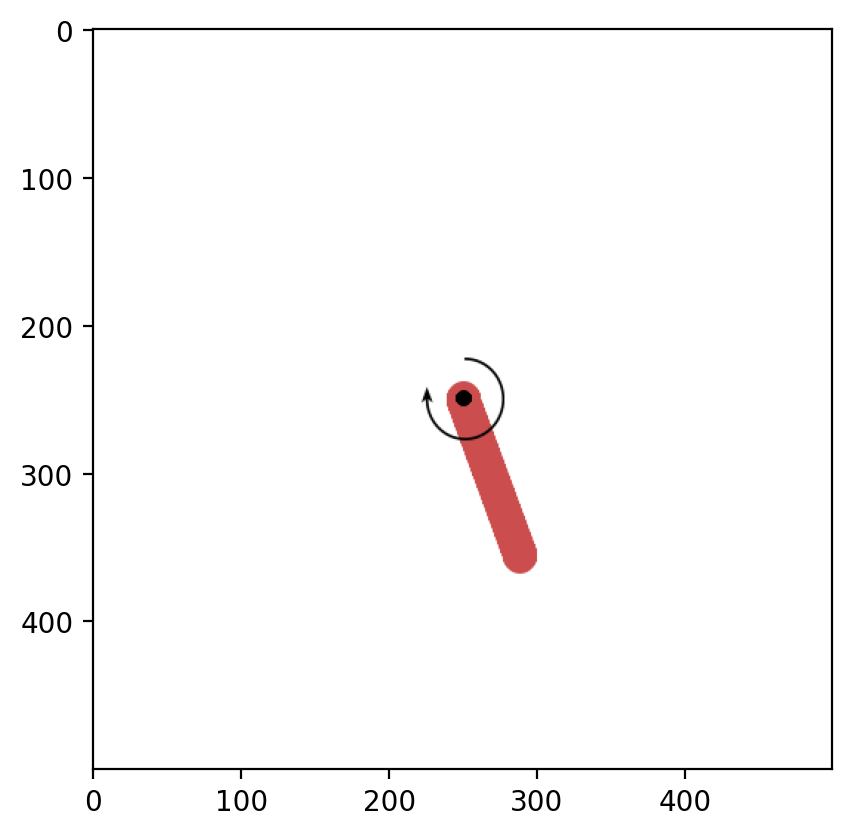

In [19]:
# Now try this policy on the real system
state, _ = env_test.reset()
key, subkey = jr.split(key)
u = control_policy(state,0.0)
# Randomly sample some points
img = plt.imshow(env_test.render()) # only call this once
for timestep in np.linspace(0,5000*T_exploration,int(T_exploration/sim_timestep)+1):
    z = env_test.step(np.array(u))
    state = z[0]
    r = z[1]
    key, subkey = jr.split(key)
    u = control_policy(state,timestep)
    img.set_data(env_test.render()) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)